In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [7]:
file_path = "C:\\Users\\ROG\\OneDrive\\Desktop\\Projects\\AI-Sprint\\ARIMA\\Dataset\\DatasetNew\\train.csv"
df = pd.read_csv(file_path)
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [179]:
# Assuming your dataframe is named 'df'
# Define the starting date (e.g., January 2020)
start_date = "2020-01"

# Generate a sequence of dates corresponding to the number of rows in the dataframe
date_range = pd.date_range(start=start_date, periods=df.shape[0], freq="M")

# Add the dates to the dataframe as a new column
df["Date"] = date_range

# If you want to extract the year and month separately
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Display the dataframe to verify
df.head()

C:\Users\rmkav\AppData\Local\Temp\ipykernel_12916\3550978691.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, periods=df.shape[0], freq="M")


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Date,Year,Month
0,2,3,12669,9656,7561,214,2674,1338,2020-01-31,2020,1
1,2,3,7057,9810,9568,1762,3293,1776,2020-02-29,2020,2
2,2,3,6353,8808,7684,2405,3516,7844,2020-03-31,2020,3
3,1,3,13265,1196,4221,6404,507,1788,2020-04-30,2020,4
4,2,3,22615,5410,7198,3915,1777,5185,2020-05-31,2020,5


In [180]:
# # Step 1: Group by Channel and Region
# grouped = df.groupby(["Channel", "Region"])

# # Define a function to fit ARIMA and forecast
# def arima_forecast(group_data, feature, periods=12):
#     # Step 2: Aggregate by Date
#     group_data = group_data.groupby("Date").sum()
    
#     # Step 3: Extract feature for ARIMA
#     time_series = group_data[feature]
    
#     # Step 4: Fit ARIMA Model
#     model = ARIMA(time_series, order=(1, 1, 1))  # Example: order=(p, d, q)
#     model_fit = model.fit()

#     # Forecast future values
#     forecast = model_fit.forecast(steps=periods)

#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(time_series, label="Actual")
#     plt.plot(forecast, label="Forecast", color="red")
#     plt.legend()
#     plt.title(f"ARIMA Forecast for {feature}")
#     plt.show()

#     return forecast

# # Example: Predict Milk sales for a specific group
# channel, region = 1, 3  # Select Channel and Region
# group = grouped.get_group((channel, region))
# forecast = arima_forecast(group, feature="Milk")


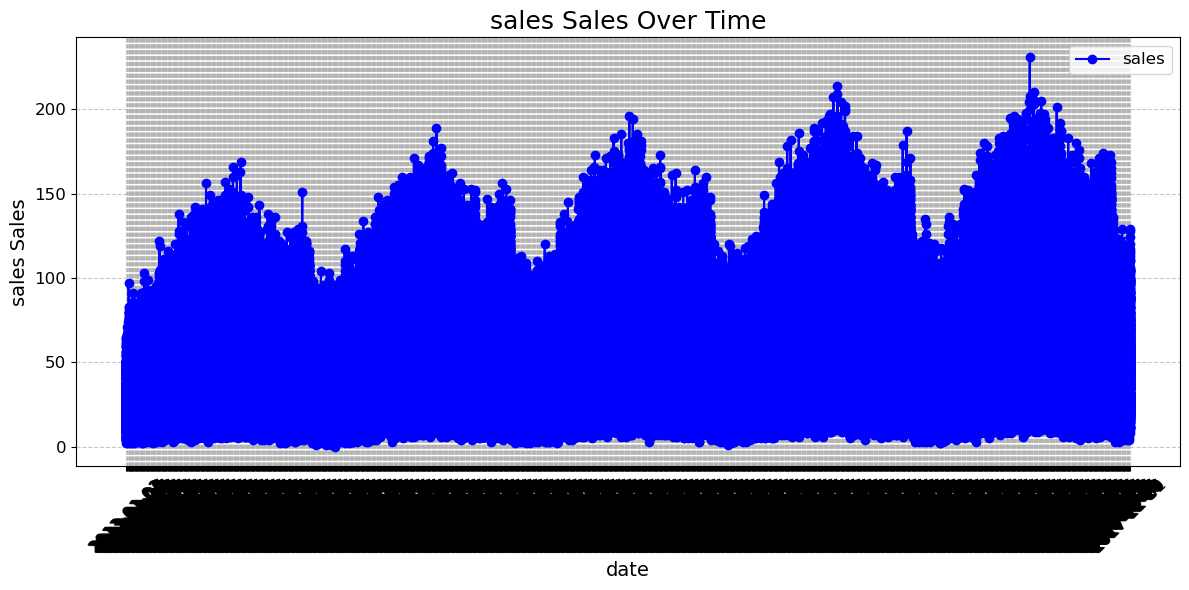

In [8]:
def plot_sales_over_time(df: pd.DataFrame, feature: str) -> None:
    """
    Function to plot sales data over time for a specific feature using matplotlib.
    
    Args:
        df (pd.DataFrame): The DataFrame containing sales data.
        feature (str): The column name of the feature to plot (e.g., 'Milk', 'Grocery').
    """
    plt.figure(figsize=(12, 6))  # Set the figure size
    plt.plot(df['date'], df[feature], marker='o', linestyle='-', label=feature, color='blue')  # Line plot
    
    # Add title and labels
    plt.title(f'{feature} Sales Over Time', fontsize=18)
    plt.xlabel('date', fontsize=14)
    plt.ylabel(f'{feature} Sales', fontsize=14)
    
    # Add grid and rotate x-axis ticks
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add legend
    plt.legend(fontsize=12)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example: Plot 'Milk' sales over time
plot_sales_over_time(df, 'sales')

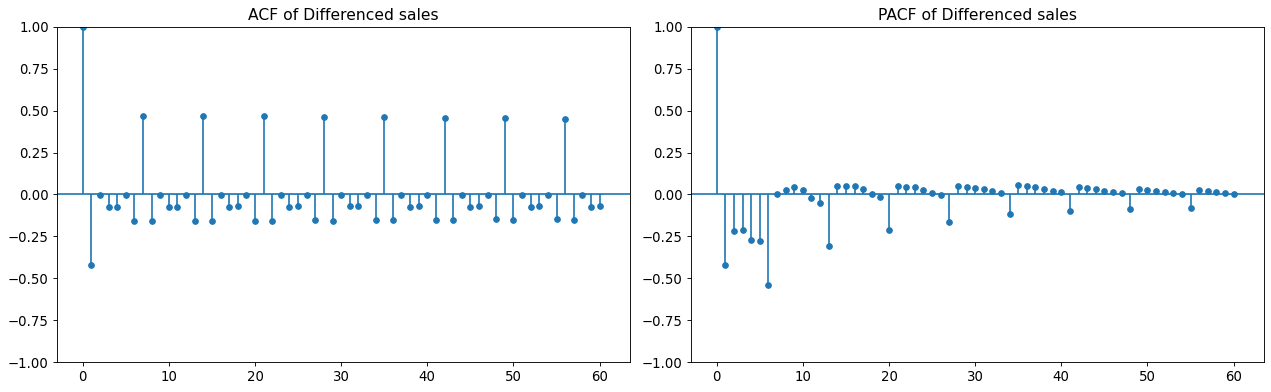

In [9]:
# Feature to analyze
feature = 'sales'

# Difference the data to make it stationary
df[f'{feature}_diff'] = df[feature].diff()

# Drop NaN values after differencing
df.dropna(inplace=True)

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)

# ACF plot
plot_acf(df[f'{feature}_diff'], ax=ax1)
ax1.set_title(f'ACF of Differenced {feature}', fontsize=14)

# PACF plot
plot_pacf(df[f'{feature}_diff'], method='ywm', ax=ax2)
ax2.set_title(f'PACF of Differenced {feature}', fontsize=14)

# Adjust tick sizes
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
# Step 1: Set 'Date' as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Feature to forecast
feature = 'sales'

# Step 2: Split data into train and test
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Step 3: Differencing (if required)
train_diff = train[feature].diff().dropna()
test_diff = test[feature].diff().dropna()

# Step 4: Fit ARIMA model
model = ARIMA(train_diff, order=(56, 1, 28))  # Replace with tuned (p, d, q)
fitted_model = model.fit()

# Step 5: Forecast
forecast_diff = fitted_model.forecast(steps=len(test_diff))

# Step 6: Revert differencing to get original scale
forecast_original = train[feature].iloc[-1] + np.cumsum(forecast_diff)

# Ensure alignment of lengths
test_aligned = test[feature].iloc[:len(forecast_original)]

# Step 7: Evaluate the model
mse = mean_squared_error(test_aligned, forecast_original)
print(f'Mean Squared Error: {mse}')

# Step 8: Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[feature], label='Training Data', color='blue')
plt.plot(test.index, test[feature], label='Test Data', color='green')
plt.plot(test.index[:len(forecast_original)], forecast_original, label='Forecast', color='red')
plt.xlabel('date')
plt.ylabel(feature)
plt.title(f'{feature} Forecast with ARIMA')
plt.legend()
plt.show()

C:\Users\ROG\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\anaconda3\Lib\site-packages\s

KeyboardInterrupt: 